# Redes Neurais de Convolução para Classificação
---
### Este caderno foi baseado no curso de visão computacional da [Udacity](https://www.udacity.com/)
Neste caderno, nós definimos e treinamos uma rede neural de convolução para classificar imagens do [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist). 


### Carregue os [dados](http://pytorch.org/docs/master/torchvision/datasets.html)

Aqui é onde carregamos os conjuntos de dados de testes e treinamento da classe FashionMNIST

In [3]:
# Bibliotecas Básicas
import torch
import torchvision

# Carregando e transformando dados
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# A saída dos datasets torchvision são images PILImage de [0, 1]
# Transformamos em tensores para entrada na rede

## Define uma transformação para ler os dados como tensores 
data_transform = transforms.ToTensor()

# escolher os datasets de treinamento e test
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Imprime status sobre os dados de treinamento e teste
print('Dados de treinamento, número de imagens: ', len(train_data))
print('Dados de treinamento, número de imagens: ', len(test_data))

Dados de treinamento, número de imagens:  60000
Dados de treinamento, número de imagens:  10000


In [4]:
# Prepara carregador de dados, escolher tamanho do lote
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Especifique as classes das imagens
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualizar alguns dados de treinamento


/Users/lucastakara/Projects/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


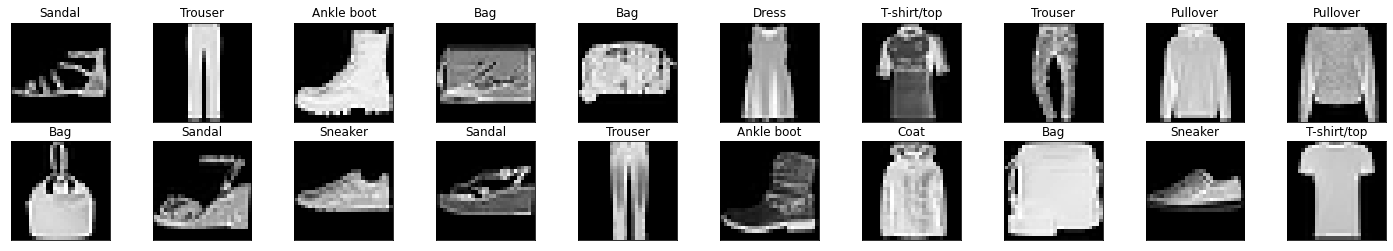

In [5]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# Obtem um lote de imagens de treinamento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Plote as imagens do lote, junto com seus rótulos correspondentes
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Definição da arquitetura da rede



Várias camadas que compõem redes neurais estão documentadas, [aqui](http://pytorch.org/docs/master/nn.html). Para uma rede neural de convolução, vamos utilizar:
* Camadas de Convolução
* Camadas Maxpooling
* Camadas Totalmente-Conectadas (linear)


Para evitar overfitting, é recomendado utilizar [camadas dropout](http://pytorch.org/docs/stable/nn.html#dropout).

---

### Tamanho de saída




Para qualquer camada de convolução, a saída dos mapas de ativação terão a profundidade específica (10 para 10 filtros em uma camada de convolução). As dimensões dos mapas de ativação produzidos, com padding 0, são computados como: `dim_saida = (W-F)/S+1.`

Mais sobre essa formula pode ser visto, [aqui](http://cs231n.github.io/convolutional-networks/#conv)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 canal de imagem (cinza), 10 canais/mapas de características de saída
        # Kernel quadrado de convolução 3x3
        # Tamanho da saída = (W-F)/S + 1 = (28-3)/1+1 = 26
        # Tensor de saída para uma imagem, terá dimensões: (10, 26, 26)
        # Após uma camada de pooling, será (10, 26, 26)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # camada maxpool 
        # pool com kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # Segunda camada de convolução: 10 entradas, 20 saídas, kernel 3x3
        # Tensor de saída terá dimensões: (20, 11, 11)
        # Após outra camada de pooling, será (20, 5, 5); 5.5 arredondado para baixo
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        # 20 saidas * tamanho dos mapas filtrados 5*5 
        # 10 canais de saidas (para as 10 classes)
        self.fc1 = nn.Linear(20*5*5, 10)
        

    # Definir feedforward
    def forward(self, x):
        # two conv/relu + pool layers
        # 2 camadas conv/relu + pool 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Preparar para a camada linear
        # Achata as entradas em um vector
        x = x.view(x.size(0), -1)
        
        # Uma camada linear Totalmente conectada
        x = self.fc1(x)
        # Camada softmax converte as notas das classas em probabilidades 
        x = F.log_softmax(x, dim=1)
        
        # Saída final
        return x

# Instancie e imprima sua Rede!
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


### Especifique a função de perda e otimizador

Mais sobre [funções de perda](http://pytorch.org/docs/master/nn.html#loss-functions) e [otimizadores](http://pytorch.org/docs/master/optim.html).

Para um problema de classificação, tipicamente se usa perda de entropia cruzada. Pode ser utilizada `criterion = nn.CrossEntropyLoss()`; Perda de entropia cruzada combina `softmax`e `NLL loss`.

Tente utilizar otimizadores diferentes como Adam. 


In [8]:
import torch.optim as optim

## Especifique a função de perda
## A função perda de entropia cruzada combinada softmax e nn.NLLLoss() em uma classe
criterion = nn.NLLLoss()

# Gradiente Descendente Estocástico com uma taxa de aprendizado pequena

optimizer = optim.SGD(net.parameters(), lr=0.001)

### Acurácia do modelo antes de treinar


In [12]:
# Calcular acurácia antes do treinamento
correct = 0
total = 0

# Itera pelo conjunto de dados
for images, labels in test_loader:

    # forward pass para pegar as saídas
    # as saídas são uma série de notas de classes
    outputs = net(images)

    # pegue a classe prevista do valor maximo na lista-saída de notas das classes
    _, predicted = torch.max(outputs.data, 1)

    # Conte o número total de rótulos corretos
    # para os rótulos que foram previstos e rótulos reais são iguais
    total += labels.size(0)
    correct += (predicted == labels).sum()

# Calcular a acurácia
accuracy = 100.0 * correct.item() / total

# imprimir
print('Acurácia antes de treinar : ', accuracy)

Acurácia antes de treinar :  10.0


### Treinar

In [13]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # Pegue as imagens de entrada e seus rótulos correspondentes
            inputs, labels = data

            # zerar o parametro (pesos) gradients
            optimizer.zero_grad()

            # forward pass para pegar saídas
            outputs = net(inputs)

            # calcular a perda
            loss = criterion(outputs, labels)

            # backward pass para calcular o gradient dos parametros
            loss.backward()

            # atualizar os parâmetros
            optimizer.step()

            # imprimir a estatística de perda
            # converter perda em escalar e adicionar a running_loss
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # imprime a cada 1000 lotes
                avg_loss = running_loss/1000
                # grava e imprimi a perda média em cima de 1000 lotes
                loss_over_time.append(avg_loss)
                print('Época: {}, Lote: {}, Perda Média: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Fim do Treinamento')
    return loss_over_time


In [14]:
# Defina o número de épocas para treino
n_epochs = 30 

# Chame a função treinar 
training_loss = train(n_epochs)

Época: 1, Lote: 1000, Perda Média: 2.2586147162914276
Época: 1, Lote: 2000, Perda Média: 1.8943558766841888
Época: 1, Lote: 3000, Perda Média: 1.145917047560215
Época: 2, Lote: 1000, Perda Média: 0.9204349008798599
Época: 2, Lote: 2000, Perda Média: 0.8465314574539662
Época: 2, Lote: 3000, Perda Média: 0.7867277444005013
Época: 3, Lote: 1000, Perda Média: 0.7625725404322148
Época: 3, Lote: 2000, Perda Média: 0.7548300066739321
Época: 3, Lote: 3000, Perda Média: 0.727936909481883
Época: 4, Lote: 1000, Perda Média: 0.7152343076765537
Época: 4, Lote: 2000, Perda Média: 0.7015045057535172
Época: 4, Lote: 3000, Perda Média: 0.6916431811153889
Época: 5, Lote: 1000, Perda Média: 0.6837039439082145
Época: 5, Lote: 2000, Perda Média: 0.6641589284837246
Época: 5, Lote: 3000, Perda Média: 0.6522283239066601
Época: 6, Lote: 1000, Perda Média: 0.6460141902416945
Época: 6, Lote: 2000, Perda Média: 0.6378860646188259
Época: 6, Lote: 3000, Perda Média: 0.6223145175129176
Época: 7, Lote: 1000, Perda Mé

## Visualizando a perda

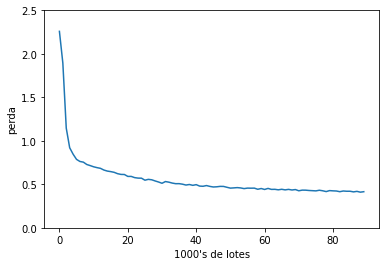

In [15]:
# Visualizar a perda 
plt.plot(training_loss)
plt.xlabel('1000\'s de lotes')
plt.ylabel('perda')
plt.ylim(0, 2.5) 
plt.show()

### Teste a Rede Neural
 
Um bom modelo deve alcancar acurácia **maior do que 85%** nesse conjunto de dados. Caso não chegue, tente treinar por um número maior épocas, mexer nos hyperparametros e adicionar/retirar camadas da rede.  

In [16]:
# Inicialize o tensor e listas para monitorar a acurácia e a perda do teste
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Aplique o módulo para avaliação
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # pegue as imagens de entrada e seus rótulos correspondentes
    inputs, labels = data
    
    # forward pass para pegar as saídas
    outputs = net(inputs)

    # Calcular a perda
    loss = criterion(outputs, labels)
            
    # atualizamos a perda média do teste
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # Pegamos as classes previstas do valor maximo na lista de saída de notas das classes
    _, predicted = torch.max(outputs.data, 1)
    
    # Comparamos as previsões aos rótulos verdadeiros
    # Cria um tensor 'correto' que contem o número de imagens corretas classificadas em um lote
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # Calcula a acurácia do teste para cada objeto classe
    # Pega o valor escalar de itens corretos para a classe
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Perda do Teste: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Teste de Acurácia de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Teste de Acurácia de %5s: N/A (sem exemplos de treinamento)' % (classes[i]))

        
print('\nTeste de Acurácia (Geral): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Perda do Teste: 0.438552

Teste de Acurácia de T-shirt/top: 82% (827/1000)
Teste de Acurácia de Trouser: 95% (955/1000)
Teste de Acurácia de Pullover: 70% (708/1000)
Teste de Acurácia de Dress: 87% (873/1000)
Teste de Acurácia de  Coat: 85% (851/1000)
Teste de Acurácia de Sandal: 93% (935/1000)
Teste de Acurácia de Shirt: 48% (482/1000)
Teste de Acurácia de Sneaker: 94% (941/1000)
Teste de Acurácia de   Bag: 95% (956/1000)
Teste de Acurácia de Ankle boot: 94% (942/1000)

Teste de Acurácia (Geral): 84% (8470/10000)


### Visualizar resultados de amostra de teste

Formato: classe prevista (classe verdadeira)

/Users/lucastakara/Projects/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


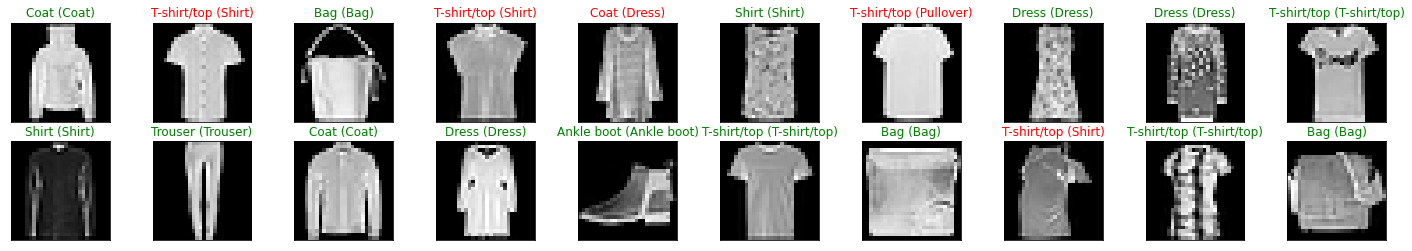

In [17]:
# Obtenha um lote de imagens teste
dataiter = iter(test_loader)
images, labels = dataiter.next()
# pegue as previsões
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plote as imagens de um lote, junto com os rótulos previsões e verdadeiros
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Qual seria a fraqueza do modelo?

**Resposta**: Esse modelo está dando overfitting em algumas classes. Adicionando algumas camadas de dropout, evitará tal fraqueza.

In [58]:
# Salvar modelo
model_dir = 'saved_models/'
model_name = 'fashion_net_simple.pt'

# Após treinamento, salve o seus parametros do modelo em 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)